In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.decomposition import PCA
from pyramid.arima import auto_arima
%matplotlib inline
warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')
df_train = df.groupby(['Store', 'Date']).agg(np.mean).drop(columns=['Dept', 'IsHoliday'])
df_t = df_train.unstack().T
df['Date'] = pd.to_datetime(df['Date'])

def return_num_week(row):
    return str(row.year) + '-' + str(row.isocalendar()[1])
df['WeekNum'] = df['Date'].apply(return_num_week)

### load_submission & test

In [5]:
def split_func(row):
    store = row.split('_')[0]
    dept = row.split('_')[1]
    return pd.Series([int(store), int(dept)])

def reset_sub(sub):
    sub.loc[:, 'Weekly_Sales'] = 0
    return sub

sub = pd.read_csv('sampleSubmission.csv')
sub[['store', 'dept']] = sub['Id'].apply(split_func)

test = pd.read_csv('test.csv')
test['Weekly_Sales'] = 0

In [318]:
def get_data(df, store=1, dept=1):
    if store is None:
        c = df['Dept'] == dept
        return df[c]
    else:
        c = df['Dept'] == dept
        c2 = df['Store'] == store
        return df[c&c2]

# missing value
- fill na by median

In [324]:
df.head(10).Date

0   2010-02-05
1   2010-02-12
2   2010-02-19
3   2010-02-26
4   2010-03-05
5   2010-03-12
6   2010-03-19
7   2010-03-26
8   2010-04-02
9   2010-04-09
Name: Date, dtype: datetime64[ns]

In [323]:
# missing value
## dept 5, store 36
get_data(df, store=36, dept=5).head(10).Date

340859   2010-02-05
340860   2010-06-04
340861   2010-06-18
340862   2010-06-25
340863   2010-07-23
340864   2010-09-17
340865   2010-10-15
340866   2010-10-22
340867   2010-10-29
340868   2010-11-05
Name: Date, dtype: datetime64[ns]

# toy example
- store 20
- dept 3

In [15]:
c = df['Store'] == 1
c2 = df['Dept'] == 3
a = df[c&c2][['Weekly_Sales', 'WeekNum']].set_index('WeekNum')
a.plot()
a.diff(52).plot()
plt.show()
a.diff(52).apply(abs).sort_values('Weekly_Sales',ascending=False).head(4).sort_index()

,Weekly_Sales
WeekNum,
2012-33,9697.14
2012-34,6062.74
2012-35,31096.83
2012-36,5590.23


# STL
- Trend: None
- Seasonality: 52 weeks

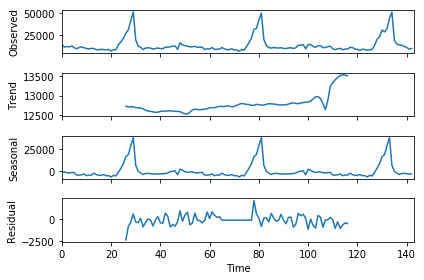

In [6]:
res = seasonal_decompose(a.values, freq=52)
res.plot()
plt.show()

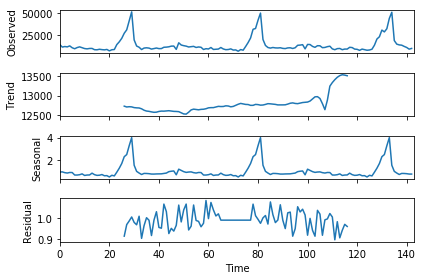

In [7]:
res = seasonal_decompose(a.values, model='multiplicative', freq=52)
res.plot()
plt.show()

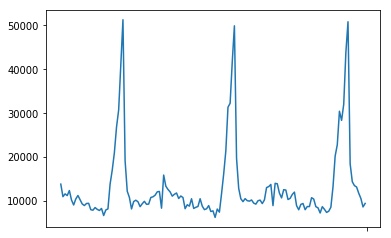

In [8]:
deseasonal = a['Weekly_Sales'] - res.seasonal
plt.plot(a['Weekly_Sales'] - res.seasonal)
plt.xticks('')
plt.show()

# ETS
- Trend: None
- Seasonality: 52 weeks
- train points 133 / test(validation) points 100

In [23]:
a['Weekly_Sales'].index = range(len(a['Weekly_Sales']))
a_data = a['Weekly_Sales']

36392.95096069646


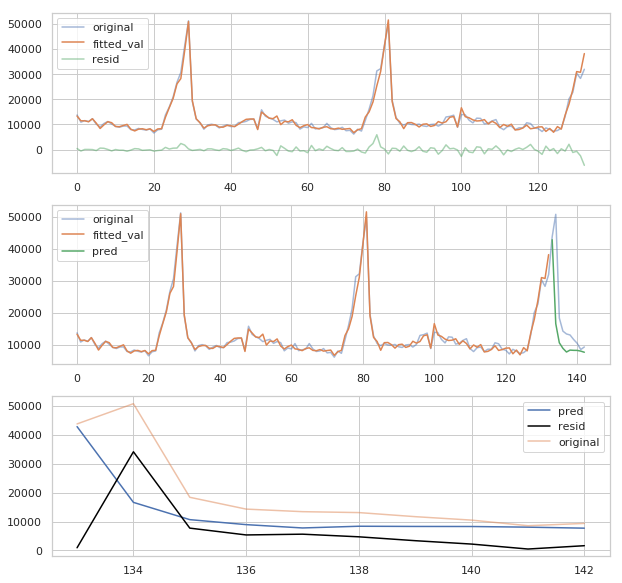

In [63]:
def ets(data, seasonal='mul', split=10):
    """
    data: pd.Series
        - row: ts
        - col: specific dept & store
    plotting: original vs pred
    """
    fit = ExponentialSmoothing(data[:-split], seasonal=seasonal, seasonal_periods=52).fit(optimized=True, remove_bias=True)
    fcst = fit.forecast(split)
    rmse = np.sqrt(sum((data[-split:].values - fcst)**2))
    print(rmse)
    
    # plotting
    len_ = len(fit.fittedvalues)
    f, ax = plt.subplots(3,1,figsize=(10, 10))
    ax[0].plot(data[:-split].values, label='original', alpha=0.5)
    ax[0].plot(pd.Series(fit.fittedvalues, index=range(len_)), label='fitted_val')
    ax[0].plot(fit.resid, alpha=0.5, label='resid',)
    ax[0].legend()
    
    ax[2].plot(pd.Series(fcst, index=range(len_, len_+split)), label='pred',)
    ax[2].plot(pd.Series(data[-split:].values - fcst, index=range(len_, len_+split)), label='resid', color='black',)
    ax[2].plot(pd.Series(data[-split:].values,index=range(len_, len_+split)), label='original', alpha=0.5)
    ax[2].legend()
    
    ax[1].plot(data.values, label='original', alpha=0.5)
    ax[1].plot(pd.Series(fit.fittedvalues, index=range(len_)), label='fitted_val')
    ax[1].plot(pd.Series(fcst, index=range(len_, len_+split)), label='pred',)
    ax[1].legend()
    plt.show()
        
    return fit

fit = ets(a_data, seasonal='mul')

- small plot ver.
    - original
    - fitted val
    - residuals

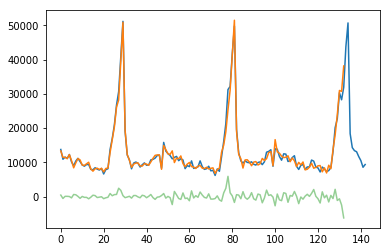

In [9]:
fit = ExponentialSmoothing(a['Weekly_Sales'].values[:-10], seasonal='mul', seasonal_periods=52).fit(optimized=True, remove_bias=True)
plt.plot(a['Weekly_Sales'].values)
plt.plot(fit.fittedvalues)
plt.plot(fit.resid, alpha=0.5)
plt.show()

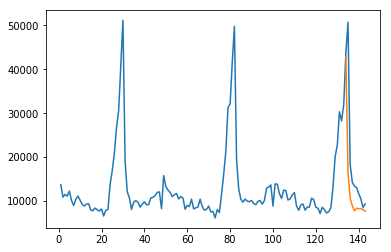

In [10]:
train = pd.Series(data=a['Weekly_Sales'].values, index=range(1, len(a.values)+1))
forecast = fit.forecast(10)
plt.plot(train)
plt.plot(pd.Series(forecast, index=range(134, 134+10)))
plt.show()

In [11]:
rmse = np.sqrt(sum((train[-10:] - forecast)**2))
rmse

36392.95086337405

# SVD
- 특정 dept의 store들은 일정한 추세를 공유함
- store를 통틀어 존재하는 것은 signal로 간주
- n_components: 12
- return: denoised data

In [12]:
c = df['Dept'] == 3
col = ['Store', 'WeekNum', 'Weekly_Sales']
df_svd = df[c][col].pivot(index='WeekNum', columns='Store', values='Weekly_Sales')
df_svd.head()

Store,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
WeekNum,,,,,,,,,,,,,,,,,,,,,
2010-10,10123.45,13061.56,4067.62,14321.78,3092.20,13118.16,6567.53,7448.76,5267.07,26163.72,...,4.96,1068.25,579.31,9376.30,5589.36,9929.60,733.83,1093.53,474.68,6995.25
2010-11,9001.37,10394.28,2444.09,12392.87,2198.92,11713.47,7489.97,5214.91,4214.67,26262.26,...,2.00,660.24,446.98,8839.48,5272.58,8765.03,816.85,712.05,537.21,7588.37
2010-12,10366.85,12406.44,4302.59,10421.50,3669.80,10987.44,6307.81,7055.28,4615.74,24155.97,...,12.23,1374.11,451.48,10284.46,5342.67,9364.82,739.40,776.73,372.56,6416.50
2010-13,11157.08,13404.23,3288.31,11626.88,3146.27,12982.37,7004.78,8091.61,5202.53,23127.46,...,5.41,1004.81,320.37,11744.52,5951.19,10202.04,717.11,1231.50,447.70,7180.17
2010-14,10179.29,12873.09,3353.84,11584.81,3118.68,11162.86,6606.86,6905.28,4874.85,24024.45,...,14.57,1214.62,468.53,10777.18,4732.78,10201.93,762.33,944.20,480.66,5491.65


- ratio of explained variance 

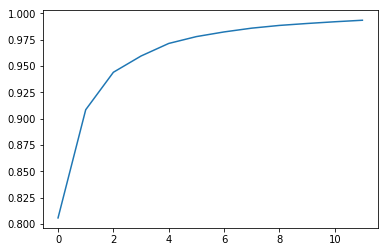

In [14]:
pca = PCA(n_components=12)
df_low = pca.fit_transform(df_svd)
df_inverse = pca.inverse_transform(df_low)

plt.plot(pd.DataFrame(pca.explained_variance_ratio_).cumsum())
plt.show()

In [15]:
idx = df_svd.index
col = df_svd.columns
df_inverse = pd.DataFrame(data=df_inverse, index=idx, columns=col)

- how much different is the denoised data with original one
    - dept 3, store 1~5

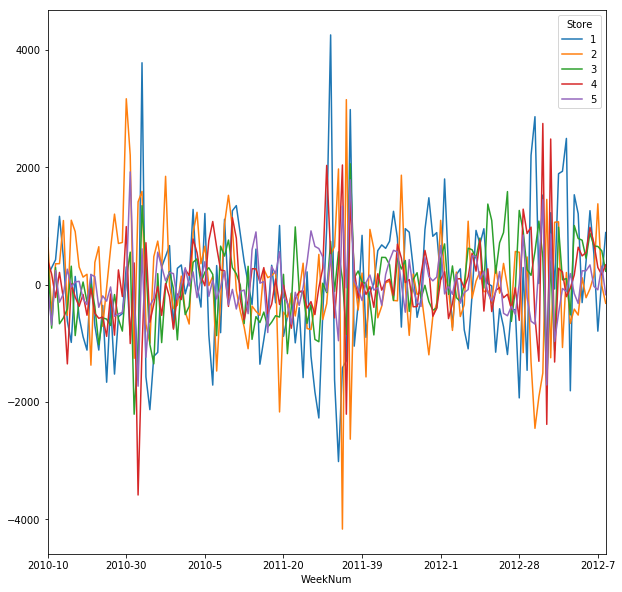

In [16]:
f, ax = plt.subplots(figsize=(10, 10))
(df_svd.iloc[:, :5]-df_inverse.iloc[:, :5]).plot(ax=ax)
plt.show()

- case: dept 3, store 21

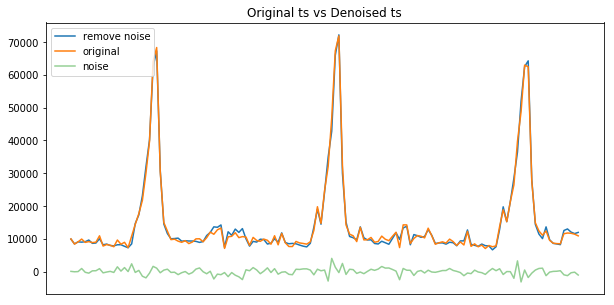

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df_inverse.iloc[:, 20], label='remove noise')
plt.plot(df_svd.iloc[:, 20], label='original')
plt.plot(df_svd.iloc[:, 20] - df_inverse.iloc[:, 20], alpha=0.5, label='noise')

plt.xticks([])
plt.title('Original ts vs Denoised ts')
plt.legend()
plt.show()

# SVD + STL

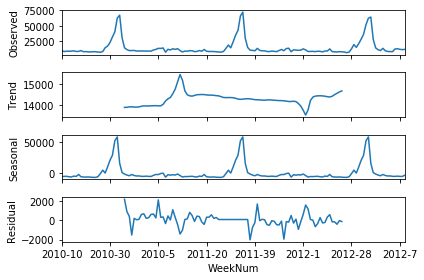

In [121]:
res1 = seasonal_decompose(df_inverse.iloc[:, 20], model='additive', freq=52)
res1.plot()
plt.show()

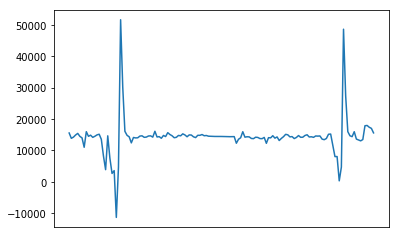

In [122]:
deseasonal = df_inverse.iloc[:, 20] - res1.seasonal
plt.plot(deseasonal)
plt.xticks([])
plt.show()

In [150]:
def autoarima(data, deseasonal_data, deseasonal=True, pred=39):
    """
    data: pd.Series
    deseasonal_data: array type
    return: re-seasonalized original data, re-seasonalized pred, model
    """
    mod = auto_arima(data, start_p=0, start_q=0, maxiter=100, trend=None, trace=False, m=52, n_fits=100)
    res = mod.fit(data)
    
    data = data + deseasonal_data
    len_ = len(data)
    
    fcst = (res.predict(pred) + deseasonal_data[-51: -51+pred]).values
    fcst = pd.Series(fcst, index=range(len_, len_+pred))

    return data, fcst, res

In [151]:
res = stl(a_data, plotting=False)

In [152]:
deseasonaled = a_data - res.seasonal
ori, fcst, res = autoarima(deseasonaled, res.seasonal)

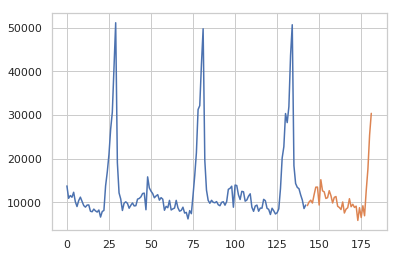

In [153]:
plt.plot(ori)
plt.plot(fcst)

- `autoariam` example

In [123]:
mod = auto_arima(deseasonal, start_p=0, start_q=0, maxiter=10000, trend=None, trace=True, m=52, n_fits=1000)
res2 = mod.fit(deseasonal)
res2

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0) seasonal_order=(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2884.180, BIC=2890.106, Fit time=0.008 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=2872.595, BIC=2884.446, Fit time=0.769 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2870.597, BIC=2879.485, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2857.197, BIC=2869.048, Fit time=0.034 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=2859.366, BIC=2874.181, Fit time=0.107 seconds


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=2860.928, BIC=2878.706, Fit time=0.093 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=2859.178, BIC=2873.992, Fit time=1.692 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2858.965, BIC=2873.779, Fit time=0.054 seconds
Total fit time: 2.805 seconds


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 0) seasonal_order=(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 0) seasonal_order=(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


ARIMA(callback=None, disp=0, maxiter=10000, method=None, order=(2, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 52), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

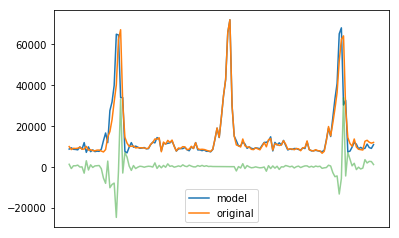

In [132]:
plt.plot(res2.predict_in_sample() + res1.seasonal, label='model')
plt.plot(df_inverse.iloc[:, 20], label='original')
plt.plot(res2.resid(), alpha=0.5)
plt.xticks([])
plt.legend()
plt.show()

- re-seasonalized data and pred

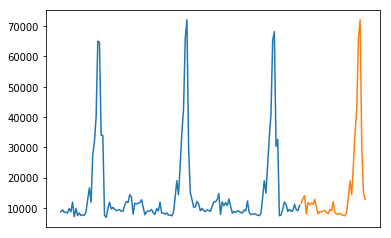

In [134]:
plt.plot(res2.predict_in_sample() + res1.seasonal, label='model')
plt.plot(pd.Series(res2.predict(39) + res1.seasonal.iloc[-51: -51+39].values, index=range(143,143+39)))
plt.xticks([])
plt.show()

# SVD + seasonally adjusted
- customed seasonal adjust: deduct avg(every 52 week)
    - eg. seasonality: avg(week no.1 + week no.(1 + 52) + ...)

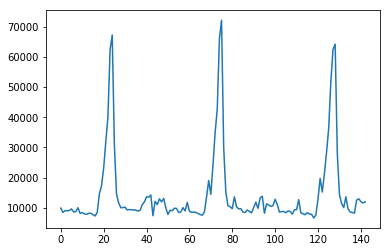

In [21]:
denoise = df_inverse.iloc[:, 20]
denoise.index = range(len(denoise))
plt.plot(denoise)
plt.show()

In [22]:
df_adjust = pd.DataFrame()
df_adjust[0] = denoise.values
df_adjust[1] = denoise.shift(-52).values
df_adjust[2] = denoise.shift(-104).values

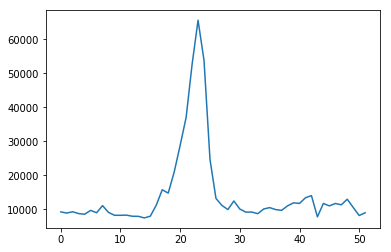

In [23]:
seasonality = df_adjust.mean(axis=1)[:52]
plt.plot(seasonality)
plt.show()

In [25]:
df_sea = seasonality.append(seasonality, ignore_index=True).append(seasonality[:39], ignore_index=True)

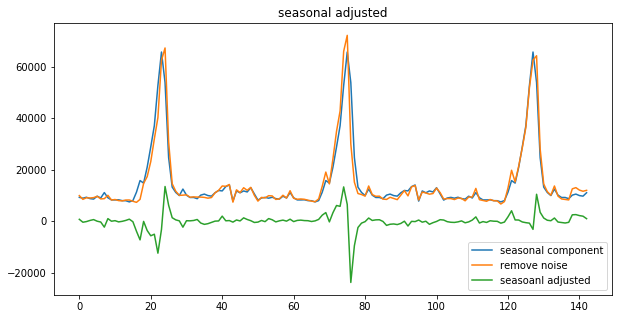

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(df_sea, label='seasonal component')
plt.plot(denoise, label='remove noise')
plt.plot(denoise - df_sea, label='seasoanl adjusted')
plt.title('seasonal adjusted')
plt.legend()
plt.show()

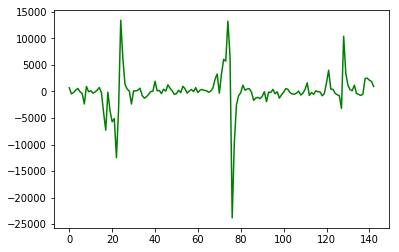

In [27]:
#resid
seasonal_adjust = denoise - df_sea
plt.plot(seasonal_adjust, color='green')
plt.show()

# SVD + seasonal adjust + SARIMA

In [61]:
mod = auto_arima(seasonal_adjust, start_p=0, start_q=0, maxiter=10000, trend=None, trace=True, m=52, n_fits=1000)
res = mod.fit(seasonal_adjust)
res

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0) seasonal_order=(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2742.256, BIC=2748.181, Fit time=0.008 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=2653.319, BIC=2665.170, Fit time=1.603 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2726.100, BIC=2734.988, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(2, 0, 0, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0) seasonal_order=(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarn

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=2671.393, BIC=2680.281, Fit time=1.282 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=2648.455, BIC=2663.270, Fit time=1.929 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 52); AIC=2649.085, BIC=2666.862, Fit time=3.606 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(1, 0, 0, 52); AIC=2650.865, BIC=2671.605, Fit time=4.120 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2718.255, BIC=2730.106, Fit time=0.028 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 0) seasonal_order=(2, 0, 0, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 0) seasonal_order=(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 0) seasonal_order=(2, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(3, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=2650.288, BIC=2668.065, Fit time=2.419 seconds
Total fit time: 15.050 seconds


ARIMA(callback=None, disp=0, maxiter=10000, method=None, order=(2, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 0, 52), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

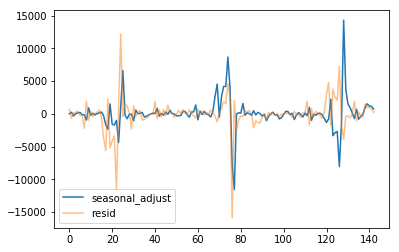

In [62]:
# plt.plot(seasonal_adjust)
plt.plot(res.predict_in_sample(), label='seasonal_adjust')
plt.plot(res.resid(), alpha=0.5, label='resid')
plt.legend()
plt.show() SVD + seasonally adjusted 

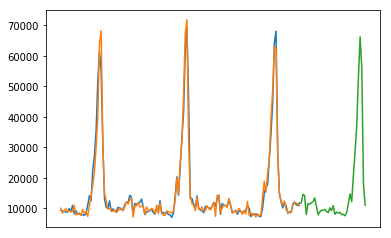

In [95]:
plt.plot(df_sea+res.predict_in_sample())
plt.plot(df_svd.iloc[:, 20])
plt.plot(pd.Series(res.predict(39) + df_sea.iloc[-51: -51+39].values, index=range(143,143+39)))
plt.xticks([])
plt.show()

# SVD + Seasonally adjusted + ETS

In [110]:
fit = ExponentialSmoothing(seasonal_adjust, trend=None, seasonal='add', seasonal_periods=52).fit(optimized=True, remove_bias=True)

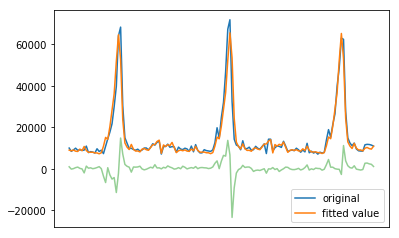

In [109]:
plt.plot(df_svd.iloc[:, 20], label='original')
plt.plot(fit.fittedvalues + df_sea.values, label='fitted value')
plt.plot(fit.resid, alpha=0.5)
plt.xticks([])
plt.legend()
plt.show()

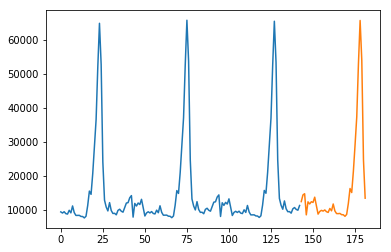

In [113]:
plt.plot(fit.fittedvalues + df_sea.values, label='fitted value')
plt.plot(pd.Series(fit.forecast(39) + df_sea.iloc[-51: -51+39].values, index=range(143,143+39)))
plt.show()

# STL + SARIMA

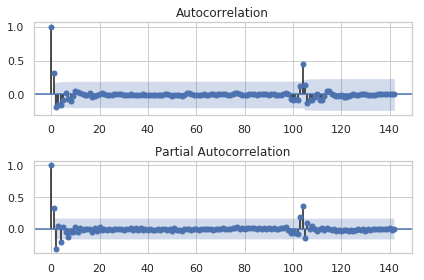

In [963]:
ax1 = plt.subplot(211)
sm.graphics.tsa.plot_acf(deseasonal, ax=ax1)
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(deseasonal, method='ywmle', ax=ax2)
plt.tight_layout()
plt.show()

In [982]:
order=(1,0,1)
seasonal_order=(1,0,0,52)
mod = sm.tsa.statespace.SARIMAX(deseasonal, order=order, seasonal_order=seasonal_order, enforce_invertibility=False, enforce_stationarity=False)
res = mod.fit()

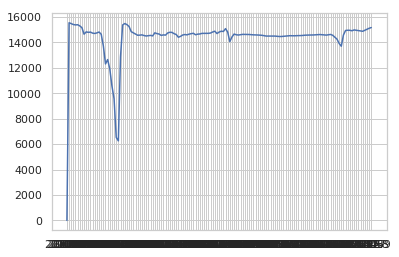

In [983]:
plt.plot(res.fittedvalues)
plt.show()

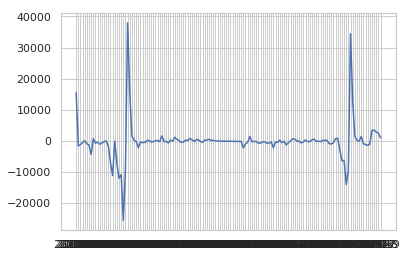

In [979]:
# fitted vs original
plt.plot(deseasonal -res.fittedvalues)

# STL + Non seasonal ARIMA

In [283]:
def split_data(train):
    """
    test: last 5 point
    dataset: len(trhain) - 5
        - train: 0.9 * len(dataset)
        - validation: 0.1 * len(dataset)
    """
    dataset, test = deseasonal[:-5], deseasonal[-5:]
    split_point = int(len(dataset)*0.9) + 2
    train, validation = dataset[:split_point], dataset[split_point:]
    return dataset, test, train, validation

def remove_season(data):
    res = seasonal_decompose(data, model='additive', freq=52)
    season_com = res.seasonal
    return season_com, data - season_com

def reverse_data(yhat, season_com, idx):
    return yhat + season_com[idx]

def arima_param(order):
    bucket = train.copy()
    pred = list()
    for i in range(len(validation)):
        season_com, d_season = remove_season(bucket)
        mod = sm.tsa.statespace.SARIMAX(d_season, order=order, enforce_stationarity=False, enforce_invertibility=False)
        res = mod.fit()
        yhat = res.forecast()[0]
        idx = bucket.index[-51]
        yhat = reverse_data(yhat, season_com, idx)
        pred.append(yhat)

        yhat_idx = res.forecast().index.strftime('%Y-%m-%d')
        bucket = bucket.append(pd.Series(validation[i], index=yhat_idx))
    rmse = np.sqrt(mean_squared_error(validation, pred))
    data['param'].append(order); data['rmse'].append(rmse)
    data['AIC'].append(res.aic); data['LLF'].append(res.llf); data['BIC'].append(res.bic);
    print(order, rmse)

In [284]:
import itertools
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

dataset, test, train, validation = split_data(df_low.iloc[:, 1])

data = {'param': [],
       'rmse': [],
       'AIC': [],
       'LLF': [],
       'BIC': []}

for order in pdq:
    arima_param(order)
df = pd.DataFrame(data)

(0, 1, 0) 1092.3137200649192
(0, 1, 1) 828.5684428779051
(0, 1, 2) 901.8874153732403
(1, 1, 0) 907.1407992335318
(1, 1, 1) 849.6664452468789
(1, 1, 2) 898.7343452333694
(2, 1, 0) 994.6764008492952
(2, 1, 1) 891.0589839451703
(2, 1, 2) 879.1702629497804


In [280]:
df = pd.DataFrame(data)
df_sorted = df.sort_values(['rmse', 'AIC', 'BIC', 'LLF'], ascending=[1, 1, 1, 0]).head(7)
df_sorted

,param,rmse,AIC,LLF,BIC
13,"(2, 0, 1)",847.794994,2195.430841,-1093.715421,2207.051940
4,"(0, 1, 1)",848.250742,2169.590383,-1082.795192,2175.386063
7,"(1, 0, 1)",849.958202,2194.170796,-1094.085398,2202.886620
10,"(1, 1, 1)",867.575989,2164.132543,-1079.066272,2172.826063
17,"(2, 1, 2)",901.473527,2149.700296,-1069.850148,2164.152041
16,"(2, 1, 1)",908.265533,2164.630857,-1078.315429,2176.222216
11,"(1, 1, 2)",917.970661,2151.664048,-1071.832024,2163.225445


# ARIMA(2, 0, 1) bias correction

In [285]:
order = (2, 0, 1)
bucket = train.copy()
pred = list()
for i in range(len(validation)):
    season_com, d_season = remove_season(bucket)
    mod = sm.tsa.statespace.SARIMAX(d_season, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit()
    yhat = res.forecast()[0]
    idx = bucket.index[-51]
    yhat = reverse_data(yhat, season_com, idx)
    pred.append(yhat)

    yhat_idx = res.forecast().index.strftime('%Y-%m-%d')
    bucket = bucket.append(pd.Series(validation[i], index=yhat_idx))
rmse = np.sqrt(mean_squared_error(validation, pred))
print(rmse)

843.7344060246081


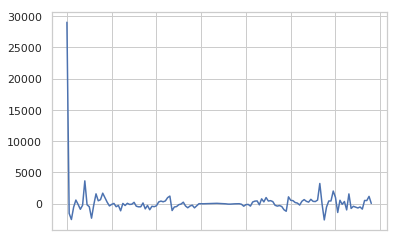

In [286]:
res.resid.plot()

In [294]:
bias = res.resid[1:-1].mean()
order = [2,0,1]

bucket = train.copy()
pred = list()
for i in range(len(validation)):
    season_com, d_season = remove_season(bucket)
    mod = sm.tsa.statespace.SARIMAX(d_season, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit()
    yhat = res.forecast()[0] + bias
    idx = bucket.index[-51]
    yhat = reverse_data(yhat, season_com, idx)
    pred.append(yhat)

    yhat_idx = res.forecast().index.strftime('%Y-%m-%d')
    bucket = bucket.append(pd.Series(validation[i], index=yhat_idx))
rmse = np.sqrt(mean_squared_error(validation, pred))
print(rmse)

846.1010091042509


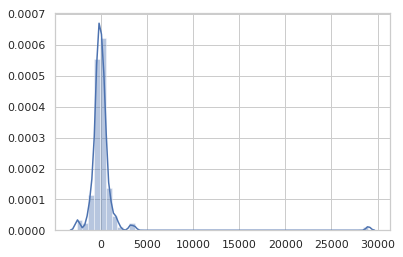

In [297]:
sns.distplot(res.resid)
plt.show()

## rolling forecst

In [307]:
def rolling_forecast(order, ax):
    bucket = dataset.copy()
    pred = list()
    for i in range(len(test)):
        season_com, d_season = remove_season(bucket)
        mod = sm.tsa.statespace.SARIMAX(d_season, order=order, enforce_stationarity=False, enforce_invertibility=False)
        res = mod.fit()
        yhat = res.forecast()[0] + bias
        idx = bucket.index[-51]
        yhat = reverse_data(yhat, season_com, idx)
        pred.append(yhat)
        print('Predicted: {} Obs: {}'.format(yhat, test[i]))
        yhat_idx = res.forecast().index.strftime('%Y-%m-%d')
        bucket = bucket.append(pd.Series(yhat, index=yhat_idx))
    rmse = np.sqrt(mean_squared_error(test, pred))
    print('order: {} RMSE: {}'.format(order, rmse))
    ax.plot(pred, label='pred', color='red')
    ax.plot(test.values, label='obs')

Predicted: 27524.833478596123 Obs: 27101.46090238195
Predicted: 27512.92734537018 Obs: 27984.816059327244
Predicted: 27556.682670804374 Obs: 27968.667331097018
Predicted: 27549.14273003293 Obs: 27310.678089700195
Predicted: 27537.38841705119 Obs: 27343.451532485586
order: [2, 0, 1] RMSE: 365.0017963930471


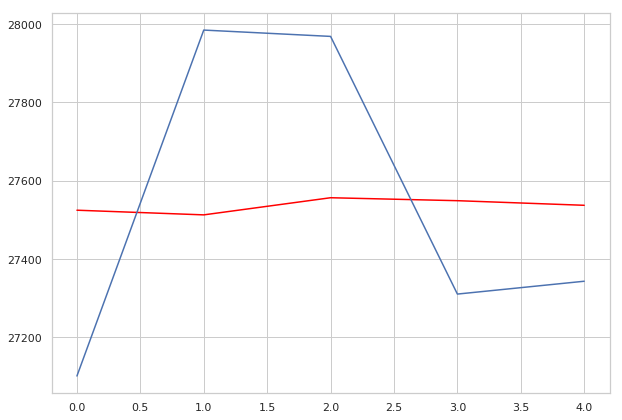

In [308]:
f, ax = plt.subplots(figsize=(10, 7))
order = [2, 0, 1]
rolling_forecast(order, ax)